### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import hessians

### Explanations here

블록 여러개로 더 나누고 설명 적기

In [2]:
# 모델 정의
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out


input_dim = 5
output_dim = 1
model = LinearRegression(input_dim, output_dim)

# 손실함수 및 최적화 함수 정의
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [3]:
np.random.seed(3)
num_samples = 1000
num_toxic_samples = 400
x = np.random.rand(num_samples, 5)

y = 1 * x[:, 0:1] + 3 * x[:, 1:2] - 5 * x[:, 2:3] \
    + 3 * x[:, 3:4] - 6 * x[:, 4:5] \
    + 1 + np.random.randn(num_samples, 1)
y[:num_toxic_samples] = - y[:num_toxic_samples] * 10

# Randomly correlate each variables
h = np.random.uniform(size=(5,5))
x = x @ h
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

### Optimized model for all data

In [4]:
model_1 = LinearRegression(input_dim, output_dim)
criterion_1 = nn.MSELoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01)

epochs = 10000
for _ in range(epochs):
    y_pred = model_1(x_tensor)
    loss = criterion_1(y_pred, y_tensor)
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()

print(model_1.linear.weight)

Parameter containing:
tensor([[ -8.7282, -25.8268,  -5.4759,   8.7476,  29.1232]],
       requires_grad=True)


### Optimized model for desirable data

In [5]:
model_2 = LinearRegression(input_dim, output_dim)
criterion_2 = nn.MSELoss()
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [6]:
epochs = 10000
for _ in range(epochs):
    y_pred = model_2(x_tensor[num_toxic_samples:])
    loss = criterion_2(y_pred, y_tensor[num_toxic_samples:])
    optimizer_2.zero_grad()
    loss.backward()
    optimizer_2.step()

print(model_2.linear.weight)

Parameter containing:
tensor([[ 2.2340,  6.4248,  2.1349, -2.2066, -7.8851]], requires_grad=True)


In [7]:
w = model_1.linear.weight.view(-1).detach().numpy()

search_width = 200
w1_values = np.arange(-search_width, search_width, .8)
w2_values = np.arange(-search_width, search_width, .8)
loss_values = np.zeros((len(w1_values), len(w2_values)))

# 손실값 계산
bias = 1
model.linear.bias = nn.Parameter(torch.Tensor([bias]))
m1_weight =  model_1.linear.weight.view(-1)
for i in range(len(w1_values)):
    for j in range(len(w2_values)):
        w = torch.Tensor([w1_values[i], w2_values[j], m1_weight[2],  m1_weight[3],  m1_weight[4]]).unsqueeze(0)
        model.linear.weight = nn.Parameter(w)
        y_pred = model(x_tensor[num_toxic_samples:])
        loss = criterion(y_pred, y_tensor[num_toxic_samples:])
        loss_values[i][j] = loss.item()

min_index = np.unravel_index(np.argmin(loss_values), loss_values.shape)
map_center = (w1_values[min_index[0]], w2_values[min_index[1]])

In [8]:
w = model_1.linear.weight.view(-1).detach().numpy()
y_pred = model_1(x_tensor[num_toxic_samples:])
total_loss = criterion(y_pred, y_tensor[num_toxic_samples:])
one_loss = criterion(model_1(x_tensor[:num_toxic_samples]), y_tensor[:num_toxic_samples])

one_gradient = hessians.compute_gradient(one_loss, model_1)
total_hessian = hessians.compute_hessian(total_loss, model_1)
index_list = [0,1]
partial_hessian = total_hessian[:, index_list]

# print("Hessian:")
# print(total_hessian)
# print("Gradient:")
# print(one_gradient, '\n')
print("Influence function")
IF = torch.inverse(total_hessian) @ one_gradient 
print(IF)

print(f"Actual PIF for index {index_list}:")
PIF = torch.linalg.inv(partial_hessian.T @ partial_hessian)\
    @ partial_hessian.T \
    @ one_gradient 
print(PIF)

print(f"Freezed IF for index {index_list}:")
FIF = torch.inverse(total_hessian[:2, :2]) @ one_gradient[index_list]
print(FIF)

reg = 10
IF /= reg 
PIF /= reg
FIF /= reg

Influence function
tensor([ 184.2176,  170.8995,  338.1464, -758.8411,  374.7873,    9.8262])
Actual PIF for index [0, 1]:
tensor([  6.4517, -11.5472])
Freezed IF for index [0, 1]:
tensor([-7.7225,  1.4492])


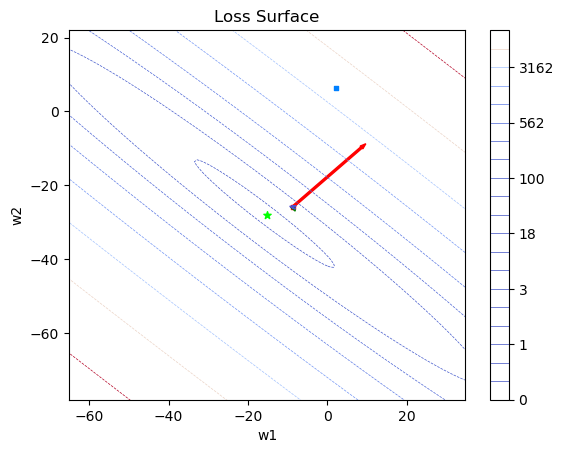

In [9]:
map_length_w1 = 50
map_length_w2 = 50

plt.title("Loss Surface")
plt.xlabel("w1")
plt.ylabel("w2")
plt.xlim(map_center[0] - map_length_w1, map_center[0] + map_length_w1)
plt.ylim(map_center[1] - map_length_w2, map_center[1] + map_length_w2)


# 그래프 그리기
X, Y = np.meshgrid(w1_values, w2_values)
levels = np.logspace(-1, 4, 21, base=10)

cmap = plt.get_cmap('coolwarm') # colormap 지정
plt.contour(X, Y, loss_values.T, levels=levels, 
            cmap=cmap,
            linewidths=.5, linestyles='--')
plt.colorbar()

w = model_2.linear.weight.view(-1).detach().numpy()
plt.scatter(w[0], w[1], s=5, color=(0, .5, 1), marker='s')

w = model_1.linear.weight.view(-1).detach().numpy()
plt.scatter(w[0], w[1], s=5, color=(1, 0, 0), marker='s')

plt.scatter(map_center[0], map_center[1], s=30, color=(0, 1, 0), marker='*')


# 화살표 그리기
plt.arrow(w[0], w[1], IF[0], IF[1], color='red', width=.5, head_width=1, head_length=1.5, length_includes_head=True)
plt.arrow(w[0], w[1], PIF[0], PIF[1], color='green', width=.5, head_width=1, head_length=1.5, length_includes_head=True)
plt.arrow(w[0], w[1], FIF[0], FIF[1], color=(.3, .3 , .8), width=.5, head_width=1, head_length=1.5, length_includes_head=True)


plt.show()

In [10]:
print(torch.linalg.inv(total_hessian))
print(total_hessian)
print(one_gradient)

tensor([[ 1.4807e+03,  9.6374e+02,  2.8907e+03, -6.3415e+03,  3.6492e+03,
         -1.4459e+00],
        [ 9.6344e+02,  7.3906e+02,  1.8735e+03, -4.3154e+03,  2.5033e+03,
          5.0844e+00],
        [ 2.8908e+03,  1.8742e+03,  5.7008e+03, -1.2426e+04,  7.1439e+03,
         -9.0164e-01],
        [-6.3413e+03, -4.3165e+03, -1.2425e+04,  2.7561e+04, -1.5900e+04,
         -1.1594e+01],
        [ 3.6490e+03,  2.5039e+03,  7.1431e+03, -1.5900e+04,  9.1849e+03,
          5.6364e+00],
        [-1.3612e+00,  5.1429e+00, -7.3606e-01, -1.1963e+01,  5.8497e+00,
          8.0017e+00]])
tensor([[2.2124, 2.6122, 2.0330, 3.4981, 2.8821, 2.0075],
        [2.6122, 3.2282, 2.5381, 4.2820, 3.5193, 2.4322],
        [2.0330, 2.5381, 2.0235, 3.3981, 2.8079, 1.9284],
        [3.4981, 4.2820, 3.3981, 5.7804, 4.8044, 3.2854],
        [2.8821, 3.5193, 2.8079, 4.8044, 4.0269, 2.7257],
        [2.0075, 2.4322, 1.9284, 3.2854, 2.7257, 2.0000]])
tensor([-13.2995, -15.4941, -14.9220, -28.4090, -28.0154, -14.4419])